In [29]:
from fastai.vision.all import *
from fastai.vision.gan import *
from fastai.basics import *
from fastai.callback.all import *

In [30]:
from PIL import ImageDraw, ImageFont

This will resize the image to a specified size.

In [31]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

# Crappifier, this will reduce the quality of the images. 

In [32]:
class Crappifier():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
      
  def __call__(self, fn):       
      dest = self.path_lr/fn.relative_to(self.path_hr)    
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      targ_sz = resize_to(img, 96, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      w,h = img.size
      q = random.randint(10,70)
      ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
      img.save(dest, quality=q)

The PETS dataset contains the images of various animals.

In [6]:
path = untar_data(URLs.PETS,"D:\Machine Learning Datasets");

In [33]:
path_hr = path/'images'
path_lr = path/'crappy'
path_hr

Path('C:/Users/ecilp/.fastai/data/oxford-iiit-pet/images')

In [34]:
items = get_image_files(path_hr)

In [35]:
parallel(Crappifier(path_lr, path_hr), items);

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


C:\Users\ecilp\AppData\Local\Temp\ipykernel_13500\3998300418.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')


generate the images:

<AxesSubplot:>

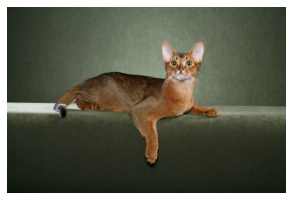

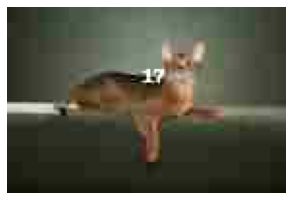

In [37]:
bad_im = get_image_files(path_lr)
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])
im1.show(); im2.show(figsize=(5,5))

DATA BLOCK 
this is the function that will set up the images for training and evaluation

In [38]:
def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls

In [39]:
dls_gen = get_dls(32, 128)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


On the left will be our 'crappified' image, and the right our original

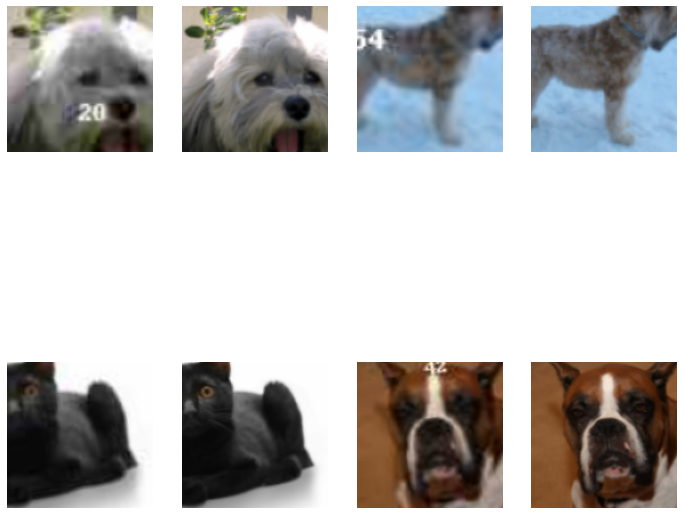

In [40]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

In [41]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [42]:
bbone = resnet34


In [48]:
learn_gen=unet_learner(dls_gen, bbone, loss_func=loss_gen,
                      blur=True, norm_type="Weight", 
                      self_attention=True,
                      y_range=y_range)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\ecilp/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:44<00:00, 1.95MB/s]


In [49]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [ ]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

In [ ]:
learn_gen.show_results(max_n=4, figsize=(12,12))